# PSAW - pushshift API Wrapper

This notebook demonstrates use of [PSAW](https://psaw.readthedocs.io/en/latest/), for anlysing historical Reddit data. This is a python wrapper for the [pushshift Redduit API](https://github.com/pushshift/api).


## Thoughts on PSAW
* Collects data as it is posted on Reddit - 1 second delay. Collects edits over less regular sweeps?
* Current day is incomplete, meaning that the current period is also incomplete. This matters less for months or longer periods.
* For multiple search terms we would need to aggregate counts of unique ID's to avoid double counting.

## Next steps
* Move into a Dash (or other dashboard) app for hosting.
* Would be easy to pull out things like top 10 subreddits for search term.
  * Could collate common terms from these subreddits to ID new topics
* Look into [pytrends](https://github.com/GeneralMills/pytrends) for searching Google Trends - note that this API might not be robust to changes in the Google API
* Look into pulling data from [GDELT BigQuery tables](https://blog.gdeltproject.org/google-bigquery-gkg-2-0-sample-queries/) for mainstread news topics


In [19]:
import datetime
import pandas as pd
from psaw import PushshiftAPI
import plotly.express as px
from pytrends.request import TrendReq
import gdelt

In [24]:
api = PushshiftAPI()

query = "coronavirus"
start_date = int(datetime.datetime(year = 2019, month = 10, day = 1).timestamp())
end_date = int(datetime.datetime.today().replace(hour=0, minute=0, second=0, microsecond=0).timestamp())  # Don't include today
frequency = "day"

In [25]:
comments_search = api.search_comments(
    q = query,
    aggs = "created_utc",
    after = start_date,
    before = end_date,
    frequency = frequency,
    size = 0
)

comments_results = next(comments_search)
comments_counts = pd.DataFrame(comments_results["created_utc"])
print(len(comments_counts))
comments_counts.key = pd.to_datetime(comments_counts.key, unit="s")  # key is in epoch time in seconds
print(comments_counts)
print(sum(comments_counts.doc_count))

322
     doc_count        key
0            1 2019-10-03
1            0 2019-10-04
2            0 2019-10-05
3            2 2019-10-06
4            1 2019-10-07
..         ...        ...
317       4777 2020-08-15
318       4812 2020-08-16
319       5557 2020-08-17
320       5492 2020-08-18
321       5203 2020-08-19

[322 rows x 2 columns]
2868357


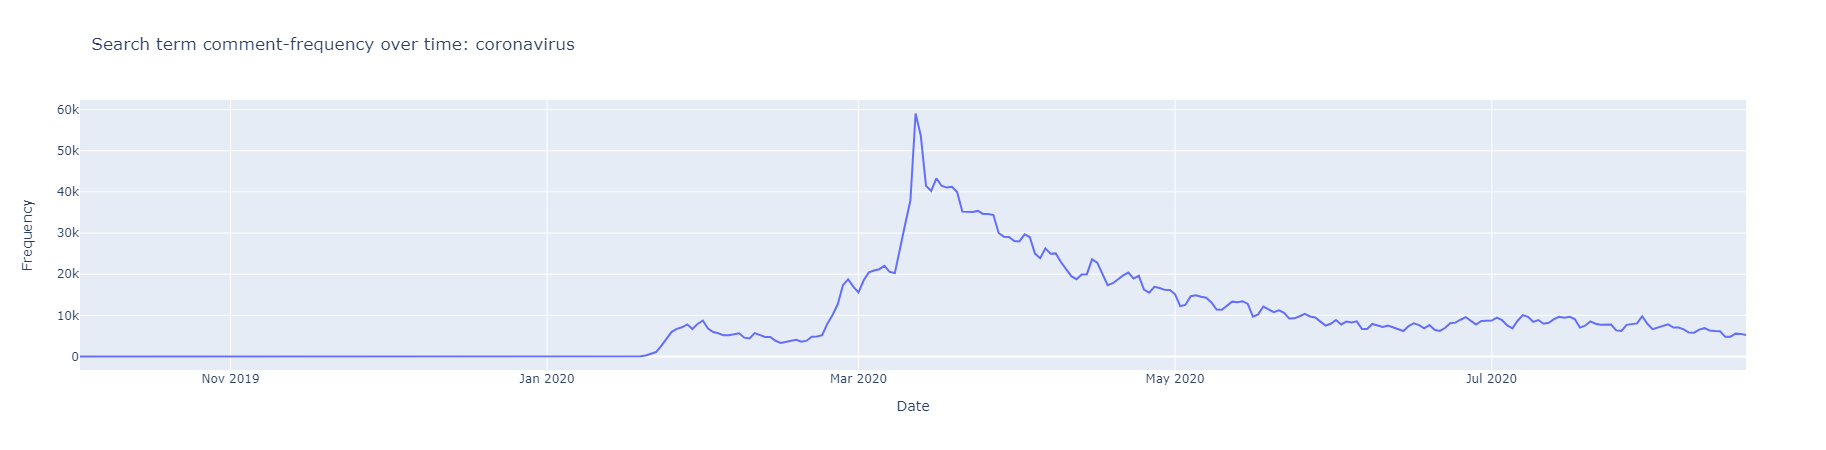

In [26]:
fig = px.line(comments_counts, x="key", y="doc_count", title="Search term comment-frequency over time: " + query, labels = {"key":"Date", "doc_count": "Frequency"})
fig.show()

In [27]:
submissions_search = api.search_submissions(
    q = query,
    aggs = "created_utc",
    after = start_date,
    before = end_date,
    frequency = frequency,
    size = 0
)

submissions_results = next(submissions_search)
submissions_counts = pd.DataFrame(submissions_results["created_utc"])
submissions_counts.key = pd.to_datetime(submissions_counts.key, unit="s")

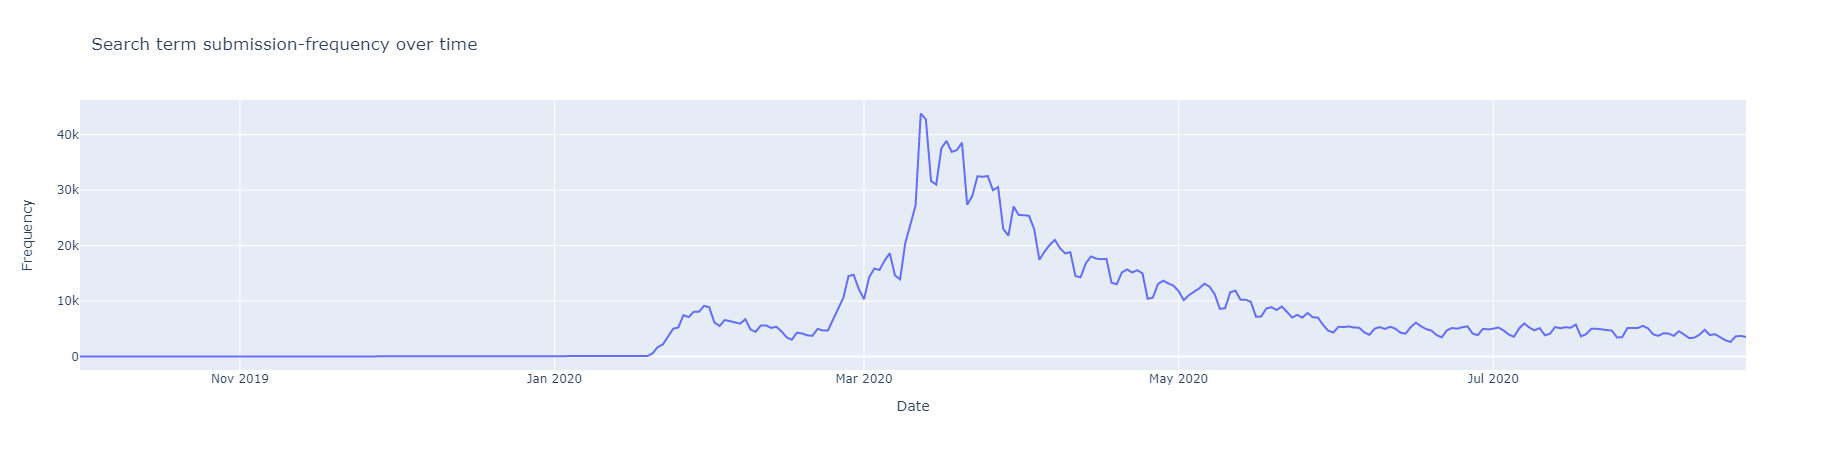

In [28]:
fig = px.line(submissions_counts, x="key", y="doc_count", title="Search term submission-frequency over time", labels = {"key":"Date", "doc_count": "Frequency"})
fig.show()

In [53]:
max_count = max(submissions_counts.doc_count)
max_date = submissions_counts.query('doc_count=={0}'.format(max_count))['key']
print('Date of peak:')
print(max_date.values[0])

Date of peak:
2020-03-12T00:00:00.000000000


# Google Trends - `pytrends`

This section demonstrates use of the `pytrends` package, for accessing the Google Trends API.

## Thoughts
* Week or so delay in available data
* Easier to collect a long range and filter to period of interest
  * But `interest_over_time` granularity seems to vary based on width of period
  * Hourly interest available, but sends 1 request per week under the hood (slow and times out) - leave it to cooldown if it times out
* 100 represents most searches across all time period and across all keywords
  * Rare keywords are easily buried by one highly popular one
  * Could fetch each keyword one by one to get historical trends, ignoring relative popularity between keywords
* Can search regionally
* Can get Related Topics and Related Queries (actual search terms)

In [31]:
kw_list = ["5G coronavirus"]
pytrends = TrendReq(hl='en-GB', tz=0)
pytrends.build_payload(kw_list, timeframe='today 12-m')
# Can select Google product using `gprop`
# Can set timeout to long value or None if timing out for hourly data

In [32]:
interest = pytrends.interest_over_time().reset_index()
interest_long = pd.melt(interest, id_vars = ["date"], value_vars = kw_list)
start_dt = datetime.datetime.fromtimestamp(start_date)
interest_filtered = interest_long[interest_long.date > start_dt]

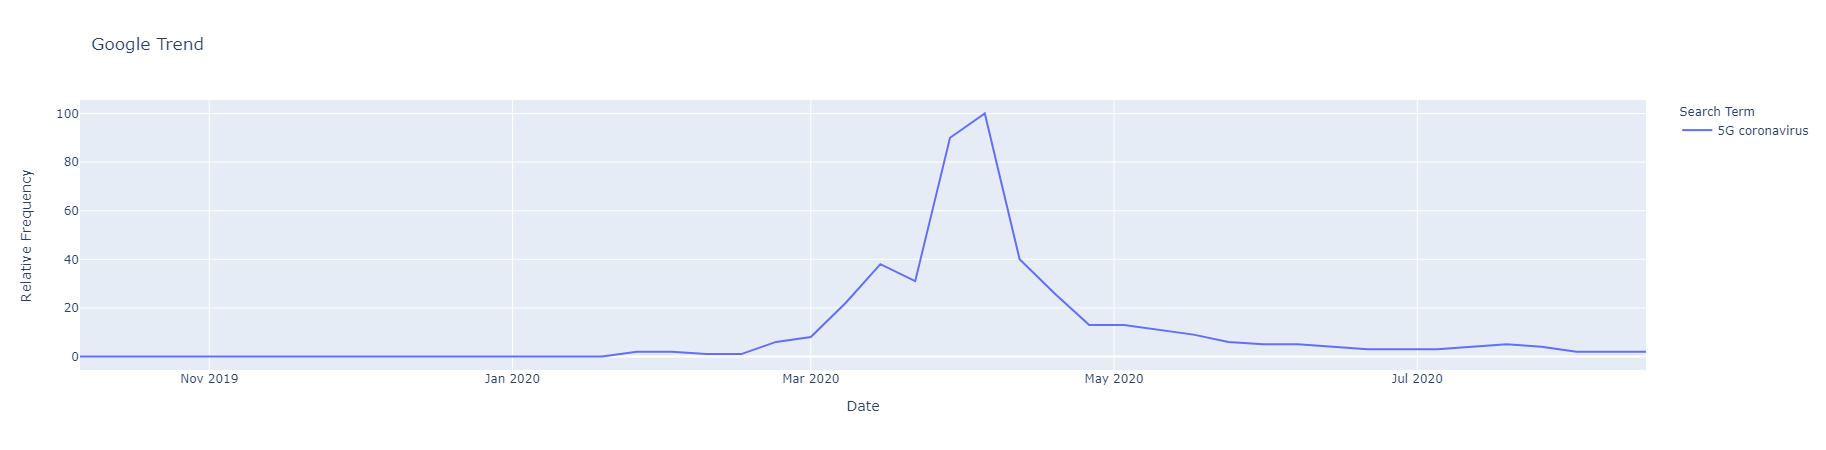

In [33]:
fig = px.line(
    interest_filtered,
    x = "date",
    y = "value",
    color = "variable",
    title = "Google Trend",
    labels = {"date":"Date", "value": "Relative Frequency", "variable": "Search Term"}
)
fig.show()

In [58]:
print('Date of peak:')
print(interest_filtered.query('value==100')['date'].values[0])

Date of peak:
2020-04-05T00:00:00.000000000


In [43]:
pytrends.related_queries()["5G coronavirus"]["top"].head()

,query,value
0,5g and coronavirus,100
1,5g is coronavirus,80
2,coronavirus conspiracy,42
3,5g towers,41
4,coronavirus conspiracy 5g,41


In [44]:
pytrends.related_queries()["5G coronavirus"]["rising"].head()

,query,value
0,5g and coronavirus,1412600
1,5g is coronavirus,1124350
2,coronavirus conspiracy,599100
3,5g towers,584650
4,coronavirus conspiracy 5g,582650


# GDELT

The [GDELT Project](https://www.gdeltproject.org/) monitors the world's broadcast, print, and web news.

Of course, there's a python API - [`gdeltPyR`](https://linwoodc3.github.io/gdeltPyR/) - for retrieving data from the project. Despite the name, install using `pip install gdelt`.
Failing this, their data is in GBQ so we can query it ourselves when authenticated.

## Versions

GDELT 1.0 is a daily dataset
* 1.0 only has ‘events’ and ‘gkg’ tables
* 1.0 posts the previous day’s data at 6AM EST of next day (i.e. Monday’s data will be available 6AM Tuesday EST)

GDELT 2.0 is updated every 15 minutes
* Some time intervals can have missing data; gdeltPyR provides a warning for missing data
* 2.0 has ‘events’,’gkg’, and ‘mentions’ tables
* 2.0 has a distinction between native english and translated-to-english news
* 2.0 has more columns


## Outputs

gdeltPyR can output results directly into several formats which include:

* pandas dataframe
* csv
* json
* geopandas dataframe (as of version 0.1.10) - handy for creating choropleth maps
* GeoJSON (coming soon version 0.1.11)
* Shapefile (coming soon version 0.1.11)

Variables are described at: http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf

## Thoughts

* Data is collated from multiple sources - `NumMentions` in events table
* Individual mentions can be view in the mentions table
* Need to find out how to decode `GLOBALEVENTID`

In [41]:
gd2 = gdelt.gdelt(version=2)

In [42]:
events = gd2.Search(['2020 08 17'], table='events',coverage=True)
events.head()

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_ADM2Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,941137209,20200810,202008,2020,2020.6027,ESP,SPAIN,ESP,NaN,NaN,...,4,"Madrid, Madrid, Spain",SP,SP29,25820,40.4000,-3.68333,-390625,20200817004500,https://www.msn.com/en-us/finance/other/spain-...
1,941137210,20200810,202008,2020,2020.6027,FRAGOV,FRENCH,FRA,NaN,NaN,...,1,Israel,IS,IS,NaN,31.5000,34.75000,IS,20200817004500,https://www.israelnationalnews.com/News/News.a...
2,941137211,20200810,202008,2020,2020.6027,FRAGOV,FRENCH,FRA,NaN,NaN,...,1,France,FR,FR,NaN,46.0000,2.00000,FR,20200817004500,https://www.israelnationalnews.com/News/News.a...
3,941137212,20200810,202008,2020,2020.6027,GOV,MINISTRY,NaN,NaN,NaN,...,4,"Toronto, Ontario, Canada",CA,CA08,12686,43.6667,-79.41670,-574890,20200817004500,https://www.thestar.com/news/gta/2020/08/16/td...
4,941137213,20200810,202008,2020,2020.6027,GOV,MINISTRY,NaN,NaN,NaN,...,4,"Toronto, Ontario, Canada",CA,CA08,12686,43.6667,-79.41670,-574890,20200817004500,https://www.thestar.com/news/gta/2020/08/16/td...


In [43]:
events.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate',
       'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent',
       'EventCode', 'CAMEOCodeDescription', 'EventBaseCode', 'EventRootCode',
       'QuadClass', 'GoldsteinScale', 'NumMentions', 'NumSources',
       'NumArticles', 'AvgTone', 'Actor1Geo_Type', 'Actor1Geo_FullName',
       'Actor1Geo_CountryCode', 'Actor1Geo_ADM1Code', 'Actor1Geo_ADM2Code',
       'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor1Geo_FeatureID',
       'Actor2Geo_Type', 'Actor2Geo_FullName', 'Actor2Geo_CountryCode',
       'Actor2Geo_ADM1Code', 'Actor2Geo_ADM2Code

In [47]:
results.AvgTone

0        -3.641882
1         5.405405
2         5.405405
3        -1.978892
4        -1.978892
            ...   
133768    0.177515
133769    0.177515
133770   -2.368421
133771   -2.368421
133772   -2.368421
Name: AvgTone, Length: 133773, dtype: float64

In [23]:
mentions = gd2.Search(['2020 08 17'], table='mentions', coverage=True)

In [24]:
mentions.GLOBALEVENTID.head()

0    941133487
1    866637976
2    941133488
3    866666669
4    941133489
Name: GLOBALEVENTID, dtype: int64